# Struc2vec on airports graph

## Imports

In [ ]:
import math
import os
import shutil
from collections import ChainMap, deque

import numpy as np
import pandas as pd
from fastdtw import fastdtw
from gensim.models import Word2Vec
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

## Utils

In [ ]:
def create_alias_table(area_ratio):
    """
    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
            (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias


def alias_sample(accept, alias):
    """
    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

In [ ]:
def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx


def partition_dict(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in vertices.items():
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_list(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in enumerate(vertices):
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

## Biased Random walker

In [ ]:
class BiasedWalker:
    def __init__(self, idx2node, temp_path):

        self.idx2node = idx2node
        self.idx = list(range(len(self.idx2node)))
        self.temp_path = temp_path
        pass

    def simulate_walks(self, num_walks, walk_length, stay_prob=0.3, workers=1, verbose=0):

        layers_adj = pd.read_pickle(self.temp_path+'layers_adj.pkl')
        layers_alias = pd.read_pickle(self.temp_path+'layers_alias.pkl')
        layers_accept = pd.read_pickle(self.temp_path+'layers_accept.pkl')
        gamma = pd.read_pickle(self.temp_path+'gamma.pkl')
        walks = []
        initialLayer = 0

        nodes = self.idx  # list(self.g.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))
        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self._exec_random_walk(layers_adj, layers_accept, layers_alias,
                                                    v, walk_length, gamma, stay_prob))
        return walks

    def _exec_random_walk(self, graphs, layers_accept, layers_alias, v, walk_length, gamma, stay_prob=0.3):
        initialLayer = 0
        layer = initialLayer

        path = []
        path.append(self.idx2node[v])

        while len(path) < walk_length:
            r = random.random()
            if(r < stay_prob):  # same layer
                v = chooseNeighbor(v, graphs, layers_alias,
                                   layers_accept, layer)
                path.append(self.idx2node[v])
            else:  # different layer
                r = random.random()
                try:
                    x = math.log(gamma[layer][v] + math.e)
                    p_moveup = (x / (x + 1))
                except:
                    print(layer, v)
                    raise ValueError()

                if(r > p_moveup):
                    if(layer > initialLayer):
                        layer = layer - 1
                else:
                    if((layer + 1) in graphs and v in graphs[layer + 1]):
                        layer = layer + 1

        return path


def chooseNeighbor(v, graphs, layers_alias, layers_accept, layer):

    v_list = graphs[layer][v]

    idx = alias_sample(layers_accept[layer][v], layers_alias[layer][v])
    v = v_list[idx]

    return v

## Model

In [ ]:
class Struc2Vec():
    def __init__(self, graph, walk_length=10, num_walks=100, workers=1, verbose=0, stay_prob=0.3, opt1_reduce_len=True, opt2_reduce_sim_calc=True, opt3_num_layers=None, temp_path='./temp_struc2vec/', reuse=False):
        self.graph = graph
        self.idx2node, self.node2idx = preprocess_nxgraph(graph)
        self.idx = list(range(len(self.idx2node)))

        self.opt1_reduce_len = opt1_reduce_len
        self.opt2_reduce_sim_calc = opt2_reduce_sim_calc
        self.opt3_num_layers = opt3_num_layers

        self.resue = reuse
        self.temp_path = temp_path

        if not os.path.exists(self.temp_path):
            os.mkdir(self.temp_path)
        if not reuse:
            shutil.rmtree(self.temp_path)
            os.mkdir(self.temp_path)

        self.create_context_graph(self.opt3_num_layers, workers, verbose)
        self.prepare_biased_walk()
        self.walker = BiasedWalker(self.idx2node, self.temp_path)
        self.sentences = self.walker.simulate_walks(
            num_walks, walk_length, stay_prob, workers, verbose)

        self._embeddings = {}

    def create_context_graph(self, max_num_layers, workers=1, verbose=0,):

        pair_distances = self._compute_structural_distance(
            max_num_layers, workers, verbose,)
        layers_adj, layers_distances = self._get_layer_rep(pair_distances)
        pd.to_pickle(layers_adj, self.temp_path + 'layers_adj.pkl')

        layers_accept, layers_alias = self._get_transition_probs(
            layers_adj, layers_distances)
        pd.to_pickle(layers_alias, self.temp_path + 'layers_alias.pkl')
        pd.to_pickle(layers_accept, self.temp_path + 'layers_accept.pkl')

    def prepare_biased_walk(self,):

        sum_weights = {}
        sum_edges = {}
        average_weight = {}
        gamma = {}
        layer = 0
        while (os.path.exists(self.temp_path+'norm_weights_distance-layer-' + str(layer)+'.pkl')):
            probs = pd.read_pickle(
                self.temp_path+'norm_weights_distance-layer-' + str(layer)+'.pkl')
            for v, list_weights in probs.items():
                sum_weights.setdefault(layer, 0)
                sum_edges.setdefault(layer, 0)
                sum_weights[layer] += sum(list_weights)
                sum_edges[layer] += len(list_weights)

            average_weight[layer] = sum_weights[layer] / sum_edges[layer]

            gamma.setdefault(layer, {})

            for v, list_weights in probs.items():
                num_neighbours = 0
                for w in list_weights:
                    if (w > average_weight[layer]):
                        num_neighbours += 1
                gamma[layer][v] = num_neighbours

            layer += 1

        pd.to_pickle(average_weight, self.temp_path + 'average_weight')
        pd.to_pickle(gamma, self.temp_path + 'gamma.pkl')

    def train(self, embed_size=128, window_size=5, workers=3, iter=5):

        # pd.read_pickle(self.temp_path+'walks.pkl')
        sentences = self.sentences

        print("Learning representation...")
        model = Word2Vec(sentences, size=embed_size, window=window_size, min_count=0, hs=1, sg=1, workers=workers,
                         iter=iter)
        print("Learning representation done!")
        self.w2v_model = model

        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

    def _compute_ordered_degreelist(self, max_num_layers):

        degreeList = {}
        vertices = self.idx  # self.g.nodes()
        for v in vertices:
            degreeList[v] = self._get_order_degreelist_node(v, max_num_layers)
        return degreeList

    def _get_order_degreelist_node(self, root, max_num_layers=None):
        if max_num_layers is None:
            max_num_layers = float('inf')

        ordered_degree_sequence_dict = {}
        visited = [False] * len(self.graph.nodes())
        queue = deque()
        level = 0
        queue.append(root)
        visited[root] = True

        while (len(queue) > 0 and level <= max_num_layers):

            count = len(queue)
            if self.opt1_reduce_len:
                degree_list = {}
            else:
                degree_list = []
            while (count > 0):

                top = queue.popleft()
                node = self.idx2node[top]
                degree = len(self.graph[node])

                if self.opt1_reduce_len:
                    degree_list[degree] = degree_list.get(degree, 0) + 1
                else:
                    degree_list.append(degree)

                for nei in self.graph[node]:
                    nei_idx = self.node2idx[nei]
                    if not visited[nei_idx]:
                        visited[nei_idx] = True
                        queue.append(nei_idx)
                count -= 1
            if self.opt1_reduce_len:
                orderd_degree_list = [(degree, freq)
                                      for degree, freq in degree_list.items()]
                orderd_degree_list.sort(key=lambda x: x[0])
            else:
                orderd_degree_list = sorted(degree_list)
            ordered_degree_sequence_dict[level] = orderd_degree_list
            level += 1

        return ordered_degree_sequence_dict

    def _compute_structural_distance(self, max_num_layers, workers=1, verbose=0,):

        if os.path.exists(self.temp_path+'structural_dist.pkl'):
            structural_dist = pd.read_pickle(
                self.temp_path+'structural_dist.pkl')
        else:
            if self.opt1_reduce_len:
                dist_func = cost_max
            else:
                dist_func = cost

            if os.path.exists(self.temp_path + 'degreelist.pkl'):
                degreeList = pd.read_pickle(self.temp_path + 'degreelist.pkl')
            else:
                degreeList = self._compute_ordered_degreelist(max_num_layers)
                pd.to_pickle(degreeList, self.temp_path + 'degreelist.pkl')

            if self.opt2_reduce_sim_calc:
                degrees = self._create_vectors()
                degreeListsSelected = {}
                vertices = {}
                n_nodes = len(self.idx)
                for v in self.idx:  # c:list of vertex
                    nbs = get_vertices(
                        v, len(self.graph[self.idx2node[v]]), degrees, n_nodes)
                    vertices[v] = nbs  # store nbs
                    degreeListsSelected[v] = degreeList[v]  # store dist
                    for n in nbs:
                        # store dist of nbs
                        degreeListsSelected[n] = degreeList[n]
            else:
                vertices = {}
                for v in degreeList:
                    vertices[v] = [vd for vd in degreeList.keys() if vd > v]

            results = Parallel(n_jobs=workers, verbose=verbose,)(
                delayed(compute_dtw_dist)(part_list, degreeList, dist_func) for part_list in partition_dict(vertices, workers))
            dtw_dist = dict(ChainMap(*results))

            structural_dist = convert_dtw_struc_dist(dtw_dist)
            pd.to_pickle(structural_dist, self.temp_path +
                         'structural_dist.pkl')

        return structural_dist

    def _create_vectors(self):
        degrees = {}  # sotre v list of degree
        degrees_sorted = set()  # store degree
        G = self.graph
        for v in self.idx:
            degree = len(G[self.idx2node[v]])
            degrees_sorted.add(degree)
            if (degree not in degrees):
                degrees[degree] = {}
                degrees[degree]['vertices'] = []
            degrees[degree]['vertices'].append(v)
        degrees_sorted = np.array(list(degrees_sorted), dtype='int')
        degrees_sorted = np.sort(degrees_sorted)

        l = len(degrees_sorted)
        for index, degree in enumerate(degrees_sorted):
            if (index > 0):
                degrees[degree]['before'] = degrees_sorted[index - 1]
            if (index < (l - 1)):
                degrees[degree]['after'] = degrees_sorted[index + 1]

        return degrees

    def _get_layer_rep(self, pair_distances):
        layer_distances = {}
        layer_adj = {}
        for v_pair, layer_dist in pair_distances.items():
            for layer, distance in layer_dist.items():
                vx = v_pair[0]
                vy = v_pair[1]

                layer_distances.setdefault(layer, {})
                layer_distances[layer][vx, vy] = distance

                layer_adj.setdefault(layer, {})
                layer_adj[layer].setdefault(vx, [])
                layer_adj[layer].setdefault(vy, [])
                layer_adj[layer][vx].append(vy)
                layer_adj[layer][vy].append(vx)

        return layer_adj, layer_distances

    def _get_transition_probs(self, layers_adj, layers_distances):
        layers_alias = {}
        layers_accept = {}

        for layer in layers_adj:

            neighbors = layers_adj[layer]
            layer_distances = layers_distances[layer]
            node_alias_dict = {}
            node_accept_dict = {}
            norm_weights = {}

            for v, neighbors in neighbors.items():
                e_list = []
                sum_w = 0.0

                for n in neighbors:
                    if (v, n) in layer_distances:
                        wd = layer_distances[v, n]
                    else:
                        wd = layer_distances[n, v]
                    w = np.exp(-float(wd))
                    e_list.append(w)
                    sum_w += w

                e_list = [x / sum_w for x in e_list]
                norm_weights[v] = e_list
                accept, alias = create_alias_table(e_list)
                node_alias_dict[v] = alias
                node_accept_dict[v] = accept

            pd.to_pickle(
                norm_weights, self.temp_path + 'norm_weights_distance-layer-' + str(layer)+'.pkl')

            layers_alias[layer] = node_alias_dict
            layers_accept[layer] = node_accept_dict

        return layers_accept, layers_alias


def cost(a, b):
    ep = 0.5
    m = max(a, b) + ep
    mi = min(a, b) + ep
    return ((m / mi) - 1)


def cost_min(a, b):
    ep = 0.5
    m = max(a[0], b[0]) + ep
    mi = min(a[0], b[0]) + ep
    return ((m / mi) - 1) * min(a[1], b[1])


def cost_max(a, b):
    ep = 0.5
    m = max(a[0], b[0]) + ep
    mi = min(a[0], b[0]) + ep
    return ((m / mi) - 1) * max(a[1], b[1])


def convert_dtw_struc_dist(distances, startLayer=1):
    """
    :param distances: dict of dict
    :param startLayer:
    :return:
    """
    for vertices, layers in distances.items():
        keys_layers = sorted(layers.keys())
        startLayer = min(len(keys_layers), startLayer)
        for layer in range(0, startLayer):
            keys_layers.pop(0)

        for layer in keys_layers:
            layers[layer] += layers[layer - 1]
    return distances


def get_vertices(v, degree_v, degrees, n_nodes):
    a_vertices_selected = 2 * math.log(n_nodes, 2)
    vertices = []
    try:
        c_v = 0

        for v2 in degrees[degree_v]['vertices']:
            if (v != v2):
                vertices.append(v2)  # same degree
                c_v += 1
                if (c_v > a_vertices_selected):
                    raise StopIteration

        if ('before' not in degrees[degree_v]):
            degree_b = -1
        else:
            degree_b = degrees[degree_v]['before']
        if ('after' not in degrees[degree_v]):
            degree_a = -1
        else:
            degree_a = degrees[degree_v]['after']
        if (degree_b == -1 and degree_a == -1):
            raise StopIteration  # not anymore v
        degree_now = verifyDegrees(degrees, degree_v, degree_a, degree_b)
        # nearest valid degree
        while True:
            for v2 in degrees[degree_now]['vertices']:
                if (v != v2):
                    vertices.append(v2)
                    c_v += 1
                    if (c_v > a_vertices_selected):
                        raise StopIteration

            if (degree_now == degree_b):
                if ('before' not in degrees[degree_b]):
                    degree_b = -1
                else:
                    degree_b = degrees[degree_b]['before']
            else:
                if ('after' not in degrees[degree_a]):
                    degree_a = -1
                else:
                    degree_a = degrees[degree_a]['after']

            if (degree_b == -1 and degree_a == -1):
                raise StopIteration

            degree_now = verifyDegrees(degrees, degree_v, degree_a, degree_b)

    except StopIteration:
        return list(vertices)

    return list(vertices)


def verifyDegrees(degrees, degree_v_root, degree_a, degree_b):

    if(degree_b == -1):
        degree_now = degree_a
    elif(degree_a == -1):
        degree_now = degree_b
    elif(abs(degree_b - degree_v_root) < abs(degree_a - degree_v_root)):
        degree_now = degree_b
    else:
        degree_now = degree_a

    return degree_now


def compute_dtw_dist(part_list, degreeList, dist_func):
    dtw_dist = {}
    for v1, nbs in part_list:
        lists_v1 = degreeList[v1]  # lists_v1 :orderd degree list of v1
        for v2 in nbs:
            lists_v2 = degreeList[v2]  # lists_v1 :orderd degree list of v2
            max_layer = min(len(lists_v1), len(lists_v2))  # valid layer
            dtw_dist[v1, v2] = {}
            for layer in range(0, max_layer):
                dist, path = fastdtw(
                    lists_v1[layer], lists_v2[layer], radius=1, dist=dist_func)
                dtw_dist[v1, v2][layer] = dist
    return dtw_dist

In [ ]:
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)


class Classifier(object):

    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y,Y_)
        print('-------------------')
        print(results)
        return results
        print('-------------------')

    def predict(self, X, top_k_list):
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = np.random.get_state()

        training_size = int(train_precent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test, Y_test)


def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

## Data

In [ ]:
!wget -q --show-progress https://github.com/shenweichen/GraphEmbedding/raw/master/data/flight/labels-brazil-airports.txt
!wget -q --show-progress https://github.com/shenweichen/GraphEmbedding/raw/master/data/flight/brazil-airports.edgelist

labels-brazil-airpo 100%[===================>]     687  --.-KB/s    in 0s      
brazil-airports.edg 100%[===================>]   5.91K  --.-KB/s    in 0s      


## Run

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s finished


Learning representation...
Learning representation done!
Training classifier using 80.00% nodes...
-------------------
{'micro': 0.7142857142857143, 'macro': 0.7357142857142858, 'samples': 0.7142857142857143, 'weighted': 0.6979591836734694, 'acc': 0.7142857142857143}


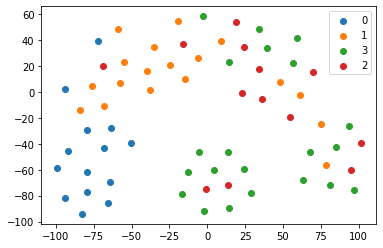

In [ ]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('labels-brazil-airports.txt',skip_head=True)
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)


def plot_embeddings(embeddings,):
    X, Y = read_node_label('labels-brazil-airports.txt',skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    G = nx.read_edgelist('brazil-airports.edgelist', create_using=nx.DiGraph(), nodetype=None,
                         data=[('weight', int)])

    model = Struc2Vec(G, 10, 80, workers=4, verbose=40, )
    model.train()
    embeddings = model.get_embeddings()
    evaluate_embeddings(embeddings)
    plot_embeddings(embeddings)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished


Learning representation...
Learning representation done!
Training classifier using 80.00% nodes...
-------------------
{'micro': 0.7857142857142857, 'macro': 0.8041666666666667, 'samples': 0.7857142857142857, 'weighted': 0.7761904761904762, 'acc': 0.7857142857142857}


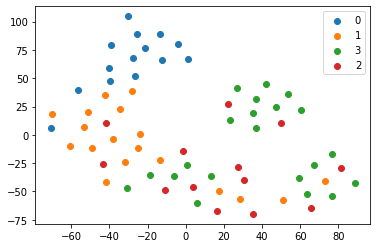

In [ ]:
DATA_GRAPH = 'labels-brazil-airports.txt'
DATA_EDGES = 'brazil-airports.edgelist'


def evaluate_embeddings(embeddings):
    X, Y = read_node_label(DATA_GRAPH, skip_head=True)
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)


def plot_embeddings(embeddings,):
    X, Y = read_node_label(DATA_GRAPH, skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    G = nx.read_edgelist(DATA_EDGES, create_using=nx.DiGraph(), nodetype=None,
                         data=[('weight', int)])

    model = Struc2Vec(G, 10, 80, workers=4, verbose=40, )
    model.train()
    embeddings = model.get_embeddings()
    evaluate_embeddings(embeddings)
    plot_embeddings(embeddings)